# Save the Chocolate
## An investigation of methods to increase cacao yields

I would like to see if the tested methods to promote natural pollinator activity resulted in an increase in cacao fruits.

Data courtesy of Emily Kearney.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
# load the data
collections = pd.read_csv('CollectingEvents.csv')
flowers = pd.read_csv('FlowerMarking.csv')
specimens = pd.read_csv('Specimen_IDs.csv')
treatmentDates = pd.read_csv('TreatmentDates.csv')
trees = pd.read_csv('TreeData.csv')

In [3]:
# I will be making lots of histograms
def plot1DHist(distribution,xlabel='',ylabel='',bins=10):
    distribution.hist(bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [4]:
# I will also be plotting some specific multi-distribution histograms
def plotMulti1DHist(df,option=''):
    tmp=[]
    for treatment in ['LB','LN','NN','NB']:
        tmp.append(df.loc[df.Treatment==treatment]['fruitCount'+option].hist(bins=5,label=treatment,histtype='step',linewidth=2))
    plt.legend()
    xlabel=''
    if option=='O':
        xlabel+='Open Pollinated '
    elif option=='H':
        xlabel+='Hand Pollinated '
    xlabel+='Fruits Per Tree'
    plt.xlabel(xlabel)
    plt.ylabel('Number of Trees') 

## Trees EDA

In [5]:
trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 9 columns):
Chakra        120 non-null object
Tree          120 non-null int64
Treatment     120 non-null object
Type          119 non-null object
Trunk Cir.    120 non-null int64
Canopy HT     117 non-null float64
Water         120 non-null object
Shade         120 non-null int64
Cover         120 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 8.6+ KB


### There are a few null values to consider...

First, the one tree with missing type.

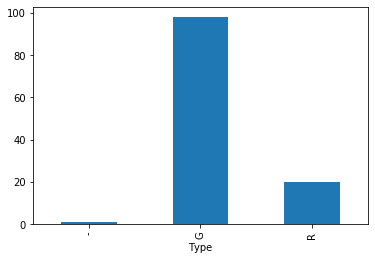

In [6]:
trees.groupby([trees.Type]).Tree.count().plot(kind='bar')

It is quite arbitrary to assign it to the majority class ... leave it as "unknown" I guess.

In [7]:
trees.fillna(value={'Type':'-'},inplace=True)

In [8]:
trees.Type.unique()

array(['G', 'R', '-'], dtype=object)

Now for trees with missing canopy height entries, fill it with the average

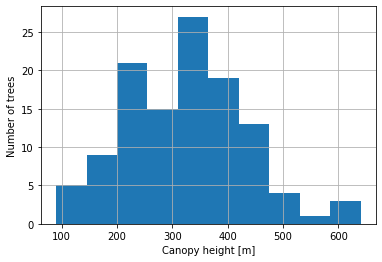

In [9]:
plot1DHist(trees['Canopy HT'],'Canopy height [m]','Number of trees')

Close to a normal distribution so this is totally valid

In [10]:
trees.fillna(value={'Canopy HT':trees['Canopy HT'].mean()},inplace=True)

### Just get a little more familiar with the trees data...

In [11]:
trees.head()

,Chakra,Tree,Treatment,Type,Trunk Cir.,Canopy HT,Water,Shade,Cover
0,CC1,1,LB,G,47,380.0,N,10,25
1,CC1,2,LB,R,82,500.0,N,0,15
2,CC1,3,LN,R,37,380.0,N,0,0
3,CC1,4,LN,G,106,260.0,N,0,5
4,CC1,5,NB,G,44,345.0,N,5,10


In [12]:
trees.loc[trees.Chakra=='CC2'].head()

,Chakra,Tree,Treatment,Type,Trunk Cir.,Canopy HT,Water,Shade,Cover
21,CC2,1,LB,G,28,310.0,N,15,15
22,CC2,2,LB,G,30,205.0,N,5,25
23,CC2,3,LN,R,40,185.0,N,30,35
24,CC2,4,LN,G,32,115.0,N,50,25
25,CC2,5,NB,G,26,220.0,N,80,80


Okay so tree IDs are not unique when integrated over all Chakras. 

#### Feature engineer
a unique id to incorporate field and tree IDs.

In [13]:
trees['ChakraTree']=trees['Chakra'].str.cat(trees['Tree'].astype(str))

In [14]:
trees['Chakra'].unique()

array(['CC1', 'CC2', 'RB1', 'RB2', 'SJ1', 'SJ2'], dtype=object)

### Keep exploring the tree data

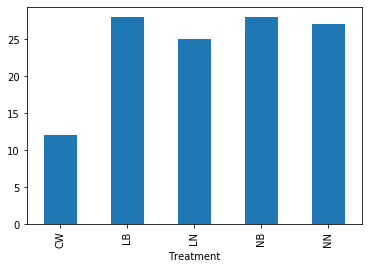

In [15]:
trees.groupby([trees.Treatment]).Tree.count().plot(kind='bar')

Experts say 'CW' treatments can be ignored.

In [16]:
trees=trees[trees.Treatment != 'CW']

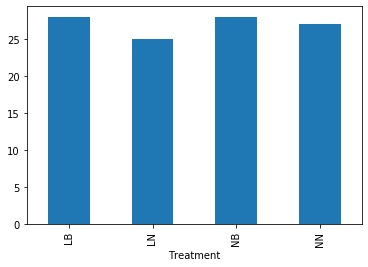

In [17]:
trees.groupby([trees.Treatment]).Tree.count().plot(kind='bar')

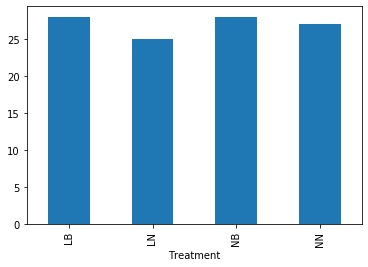

In [18]:
trees.groupby([trees.Treatment]).Tree.count().plot(kind='bar')

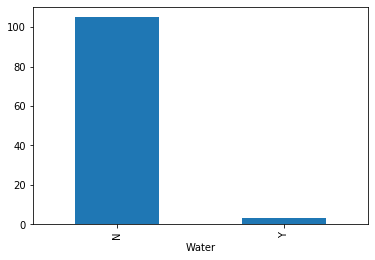

In [19]:
trees.groupby([trees.Water]).Tree.count().plot(kind='bar')

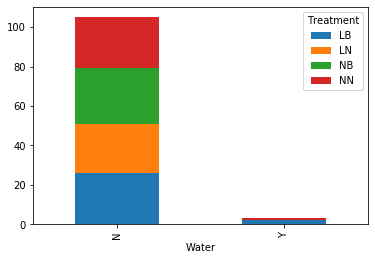

In [20]:
# check the breakdown by treatment type
trees.groupby([trees.Water,trees.Treatment]).Tree.count().unstack().plot(kind='bar',stacked=True)

(0.0, 10)

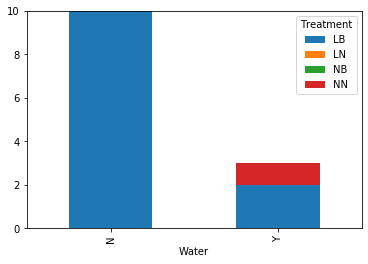

In [21]:
# zoom in
trees.groupby([trees.Water,trees.Treatment]).Tree.count().unstack().plot(kind='bar',stacked=True)
plt.ylim(top=10)

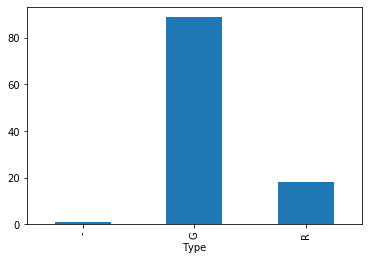

In [22]:
trees.groupby([trees.Type]).Tree.count().plot(kind='bar')

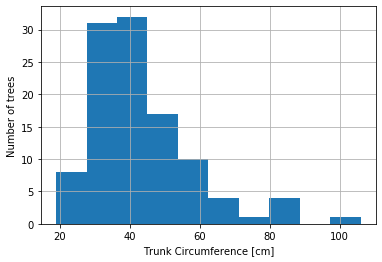

In [23]:
plot1DHist(trees['Trunk Cir.'],'Trunk Circumference [cm]','Number of trees')

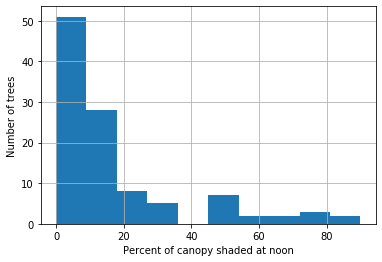

In [24]:
plot1DHist(trees['Shade'],'Percent of canopy shaded at noon','Number of trees')

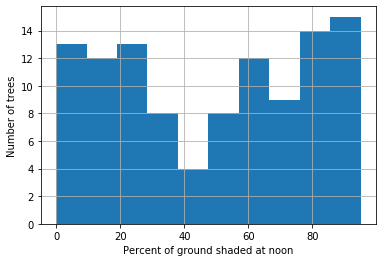

In [25]:
plot1DHist(trees['Cover'],'Percent of ground shaded at noon','Number of trees')

### Investigate if there are any strong correlations between the tree variables, in particular the treatment types.

We will need to keep this in mind before we can make any strong statements about our findings.

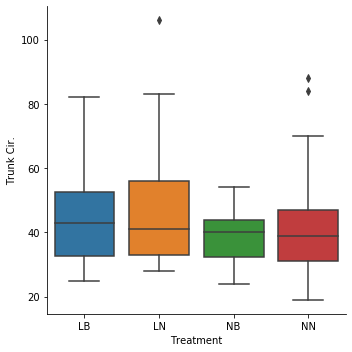

In [26]:
sns.catplot(x="Treatment", y="Trunk Cir.",
            kind="box", data=trees)

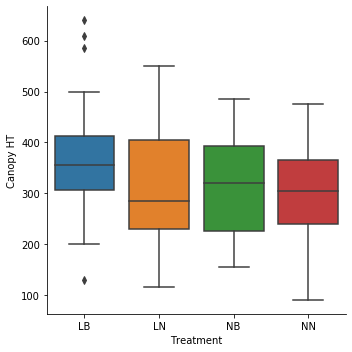

In [27]:
sns.catplot(x="Treatment", y="Canopy HT",
            kind="box", data=trees)

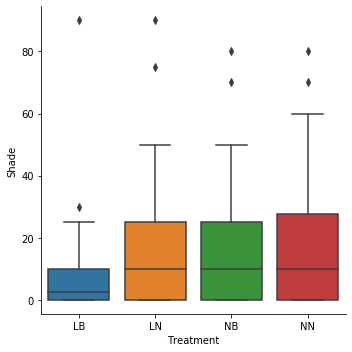

In [28]:
sns.catplot(x="Treatment", y="Shade",
            kind="box", data=trees)

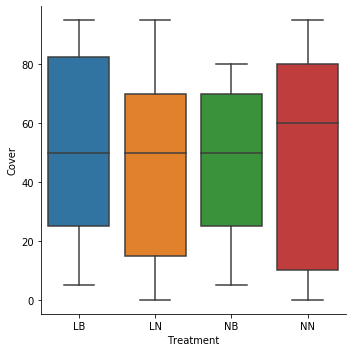

In [29]:
sns.catplot(x="Treatment", y="Cover",
            kind="box", data=trees)

There are no obvious discrepancies between the tree spec distributions and the pollination treatment administered to them. So we can treat these as a second-order effect.

## Now look at flowers data...

In [30]:
flowers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1833 entries, 0 to 1832
Data columns (total 12 columns):
CollectingEvent          1833 non-null int64
Chakra                   1833 non-null object
Tree                     1833 non-null int64
Dist                     1833 non-null object
Ht                       1833 non-null int64
Diam                     1833 non-null float64
Trt                      1833 non-null object
Branch                   1833 non-null object
Date                     1833 non-null object
Fruit (y/n)              1833 non-null object
Size (if Y for Fruit)    286 non-null object
Notes                    3 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 172.0+ KB


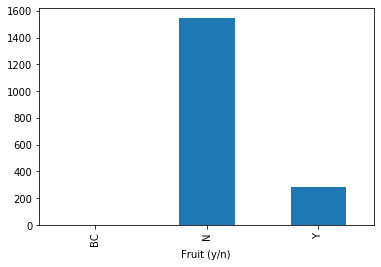

In [31]:
flowers.groupby([flowers['Fruit (y/n) ']]).Tree.count().plot(kind='bar')

In [32]:
flowers.loc[flowers['Fruit (y/n) ']=='BC']

,CollectingEvent,Chakra,Tree,Dist,Ht,Diam,Trt,Branch,Date,Fruit (y/n),Size (if Y for Fruit),Notes
760,2512,CC1,12,76,147,3.0,O,A1C,11/6/2016,BC,NaN,NaN
770,2512,CC1,11,117,188,7.0,H,B3-4,11/6/2016,BC,NaN,NaN
771,2512,CC1,11,126,196,7.0,O,B3-4,11/6/2016,BC,NaN,NaN


Experts also say we can ignore the 'BC' class.

In [33]:
flowers = flowers[flowers['Fruit (y/n) ']!='BC']

### Create the same unique field-tree ID in this dataframe.
### Then merge with trees dataframe.

In [34]:
flowers['ChakraTree']=flowers['Chakra'].str.cat(flowers['Tree'].astype(str))

In [35]:
flowers.drop(columns=['Chakra','Tree'],inplace=True)

In [36]:
flowerTrees = pd.merge(flowers,trees,on='ChakraTree',how='right')

In [37]:
flowerTrees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1837 entries, 0 to 1836
Data columns (total 20 columns):
CollectingEvent          1830 non-null float64
Dist                     1830 non-null object
Ht                       1830 non-null float64
Diam                     1830 non-null float64
Trt                      1830 non-null object
Branch                   1830 non-null object
Date                     1830 non-null object
Fruit (y/n)              1830 non-null object
Size (if Y for Fruit)    286 non-null object
Notes                    3 non-null object
ChakraTree               1837 non-null object
Chakra                   1837 non-null object
Tree                     1837 non-null int64
Treatment                1837 non-null object
Type                     1837 non-null object
Trunk Cir.               1837 non-null int64
Canopy HT                1837 non-null float64
Water                    1837 non-null object
Shade                    1837 non-null int64
Cover                 

In [38]:
flowerTrees.head()

,CollectingEvent,Dist,Ht,Diam,Trt,Branch,Date,Fruit (y/n),Size (if Y for Fruit),Notes,ChakraTree,Chakra,Tree,Treatment,Type,Trunk Cir.,Canopy HT,Water,Shade,Cover
0,2501.0,23,123.0,7.0,O,A,10/21/2016,N,NaN,NaN,CC11,CC1,1,LB,G,47,380.0,N,10,25
1,2501.0,184,201.0,1.5,H,B4C4-5,10/21/2016,N,NaN,NaN,CC11,CC1,1,LB,G,47,380.0,N,10,25
2,2501.0,94,184.0,6.0,O,A6-7,10/21/2016,N,NaN,NaN,CC11,CC1,1,LB,G,47,380.0,N,10,25
3,2501.0,87,150.0,8.0,O,B,10/21/2016,N,NaN,NaN,CC11,CC1,1,LB,G,47,380.0,N,10,25
4,2501.0,104,162.0,7.0,H,B1-2,10/21/2016,N,NaN,NaN,CC11,CC1,1,LB,G,47,380.0,N,10,25


#### Check out the number of flowers that were hand vs open pollinated

Text(0, 0.5, 'Number of flowers')

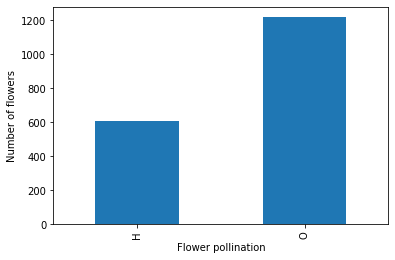

In [39]:
flowerTrees.groupby(flowerTrees['Trt']).Water.count().plot(kind='bar')
plt.xlabel('Flower pollination')
plt.ylabel('Number of flowers')

#### Now check out the number of flowers *with fruit* that were hand vs open pollinated

Text(0, 0.5, 'Number of flowers with fruit')

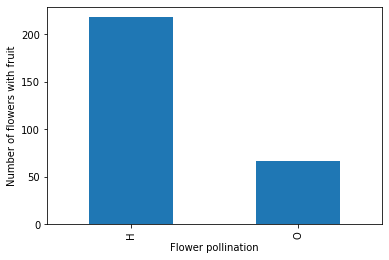

In [40]:
flowerTrees.loc[flowerTrees['Fruit (y/n) ']=='Y'].groupby(flowerTrees['Trt']).Water.count().plot(kind='bar')
plt.xlabel('Flower pollination')
plt.ylabel('Number of flowers with fruit')

So hand pollination has a much higher fruit rate than open pollination.

More EDA...

In [41]:
#flowerTrees.loc[flowerTrees['Fruit (y/n) ']=='Y']['Size (if Y for Fruit)'].astype(float).hist()
flowerTrees.loc[flowerTrees['Fruit (y/n) ']=='Y']['Size (if Y for Fruit)'].unique()

array(['1.15', '1.1', 'CW', '0.97', '1.03', '1.2', '0.4', '1', '0.5',
       '0.45', '1.35', '1.3', '1.56', '1.5', '1.47', '1.49', '1.44',
       '0.65', '1.38', '1.4', '0.35', '0.6', '0.55', '0.7', '1.25',
       '0.75', '1.05', '0.95', '0.8', '0.9', 'ID', '0.85', '0.135',
       '1.45', '1.6', '1.7'], dtype=object)

Still some cleaning up to do, we only want numbers for fruit size

In [42]:
flowerTrees['Size (if Y for Fruit)'].replace('CW',None,inplace=True)
flowerTrees['Size (if Y for Fruit)'].replace('ID',None,inplace=True)

In [43]:
# also clean up missing values
# now there will be fruit info for the "no fruit" rows as well, but that's ok, we have that info independently
flowerTrees.fillna(value={'Size (if Y for Fruit)':flowerTrees['Size (if Y for Fruit)'].astype(float).mean()},inplace=True)

In [44]:
flowerTrees.loc[flowerTrees['Fruit (y/n) ']=='Y']['Size (if Y for Fruit)'].unique()

array(['1.15', '1.1', 0.7542418772563175, '0.97', '1.03', '1.2', '0.4',
       '1', '0.5', '0.45', '1.35', '1.3', '1.56', '1.5', '1.47', '1.49',
       '1.44', '0.65', '1.38', '1.4', '0.35', '0.6', '0.55', '0.7',
       '1.25', '0.75', '1.05', '0.95', '0.8', '0.9', '0.85', '0.135',
       '1.45', '1.6', '1.7'], dtype=object)

In [45]:
flowerTrees['Size (if Y for Fruit)']=flowerTrees['Size (if Y for Fruit)'].astype(float)

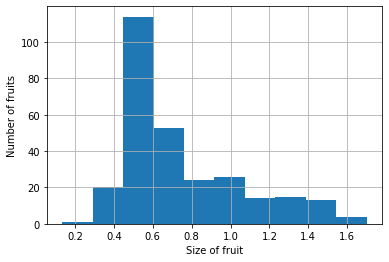

In [46]:
plot1DHist(flowerTrees.loc[flowerTrees['Fruit (y/n) ']=='Y']['Size (if Y for Fruit)'],'Size of fruit','Number of fruits')

Check: Could we target the hand-pollination to specific locations on the tree to increase fruits?

Text(26.97361111111112, 0.5, 'Flower height from ground [cm]')

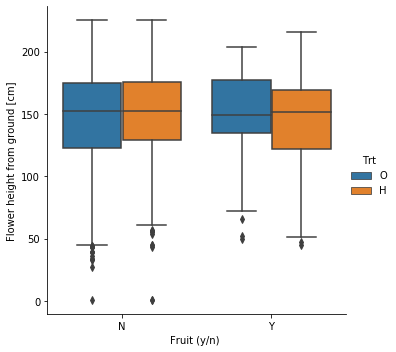

In [47]:
sns.catplot(x="Fruit (y/n) ", y="Ht",
            kind="box", data=flowers, hue='Trt')
plt.ylabel('Flower height from ground [cm]')

In [48]:
flowers['Dist'].replace('-',None,inplace=True)
flowers.fillna(value={'Dist':flowers['Dist'].astype(float).mean()},inplace=True)
flowers.Dist.unique()
flowers.Dist = flowers.Dist.astype(float)

Text(26.958420138888897, 0.5, 'Flower distance to trunk [cm]')

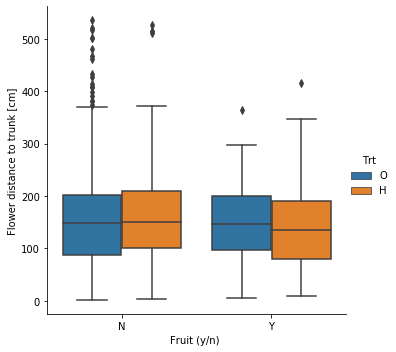

In [49]:
sns.catplot(x="Fruit (y/n) ", y="Dist",
            kind="box", data=flowers, hue='Trt')
plt.ylabel('Flower distance to trunk [cm]')

Text(27.38376736111112, 0.5, 'Branch diameter at flower location [cm]')

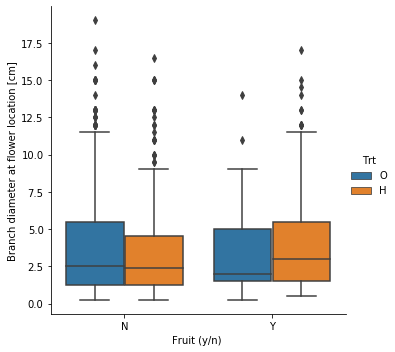

In [50]:
sns.catplot(x="Fruit (y/n) ", y="Diam",
            kind="box", data=flowers, hue='Trt')
plt.ylabel('Branch diameter at flower location [cm]')

There are no obvious dependencies here between the location of the flower and its chance of having fruit.

### Get the total count of fruits on each tree
#### Count separately for hand-pollinated and open-pollinated as well

In [51]:
flowerTrees['fruit']=flowerTrees.apply(lambda x: 1 if x['Fruit (y/n) '] =='Y' else 0 , axis=1)
flowerTrees['fruitO']=flowerTrees.apply(lambda x: 1 if x['Fruit (y/n) '] =='Y' and x['Trt']=='O' else 0 , axis=1)
flowerTrees['fruitH']=flowerTrees.apply(lambda x: 1 if x['Fruit (y/n) '] =='Y' and x['Trt']=='H' else 0 , axis=1)

In [52]:
fCount=flowerTrees.join(pd.get_dummies(flowerTrees['fruit'])).groupby('ChakraTree').agg(
    dict(fruit='sum')
)
fCountO=flowerTrees.join(pd.get_dummies(flowerTrees['fruitO'])).groupby('ChakraTree').agg(
    dict(fruitO='sum')
)
fCountH=flowerTrees.join(pd.get_dummies(flowerTrees['fruitH'])).groupby('ChakraTree').agg(
    dict(fruitH='sum')
)

fCount['fruitCount'] = fCount['fruit']
fCountO['fruitCountO'] = fCountO['fruitO']
fCountH['fruitCountH'] = fCountH['fruitH']

fCount = pd.merge(fCount,fCountO,on='ChakraTree')
fCount = pd.merge(fCount,fCountH,on='ChakraTree')
fCount.drop(columns=['fruit','fruitO','fruitH'],inplace=True)

Merge these fruit count dataframes with the existing tree and flower dataframes

(Going back to tree dataframe here because this way it's easier to count fruits per tree)

In [53]:
treeFruitCount = pd.merge(trees,fCount,on=('ChakraTree'))
flowerTrees = pd.merge(flowerTrees,fCount,on=('ChakraTree'))

In [54]:
flowerTrees.head()

,CollectingEvent,Dist,Ht,Diam,Trt,Branch,Date,Fruit (y/n),Size (if Y for Fruit),Notes,...,Canopy HT,Water,Shade,Cover,fruit,fruitO,fruitH,fruitCount,fruitCountO,fruitCountH
0,2501.0,23,123.0,7.0,O,A,10/21/2016,N,0.754242,NaN,...,380.0,N,10,25,0,0,0,2,0,2
1,2501.0,184,201.0,1.5,H,B4C4-5,10/21/2016,N,0.754242,NaN,...,380.0,N,10,25,0,0,0,2,0,2
2,2501.0,94,184.0,6.0,O,A6-7,10/21/2016,N,0.754242,NaN,...,380.0,N,10,25,0,0,0,2,0,2
3,2501.0,87,150.0,8.0,O,B,10/21/2016,N,0.754242,NaN,...,380.0,N,10,25,0,0,0,2,0,2
4,2501.0,104,162.0,7.0,H,B1-2,10/21/2016,N,0.754242,NaN,...,380.0,N,10,25,0,0,0,2,0,2


In [55]:
treeFruitCount.head()

,Chakra,Tree,Treatment,Type,Trunk Cir.,Canopy HT,Water,Shade,Cover,ChakraTree,fruitCount,fruitCountO,fruitCountH
0,CC1,1,LB,G,47,380.0,N,10,25,CC11,2,0,2
1,CC1,2,LB,R,82,500.0,N,0,15,CC12,4,0,4
2,CC1,3,LN,R,37,380.0,N,0,0,CC13,1,0,1
3,CC1,4,LN,G,106,260.0,N,0,5,CC14,4,0,4
4,CC1,5,NB,G,44,345.0,N,5,10,CC15,1,1,0


## Now! Look at fruit count per tree comparing different pollination treatments

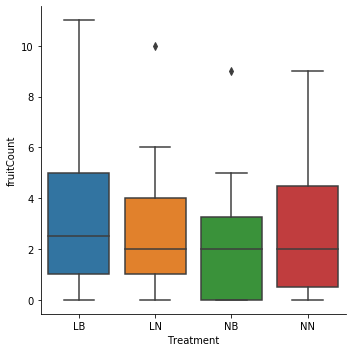

In [56]:
sns.catplot(x="Treatment", y="fruitCount",
            kind="box", data=treeFruitCount)

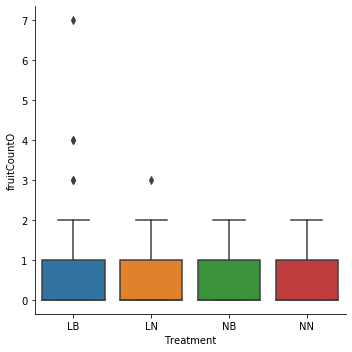

In [57]:
sns.catplot(x="Treatment", y="fruitCountO",
            kind="box", data=treeFruitCount)

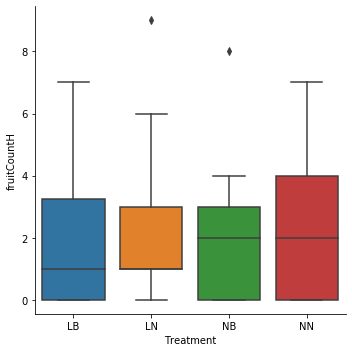

In [58]:
sns.catplot(x="Treatment", y="fruitCountH",
            kind="box", data=treeFruitCount)

#### The box plots provide clean ways to get a first look, but to really see the distribution, let's also draw the histograms

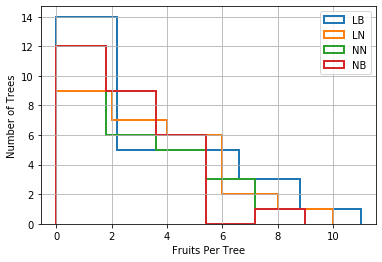

In [59]:
plotMulti1DHist(treeFruitCount)

It doesn't look like there's any difference in the fruit count when checking all flowers.

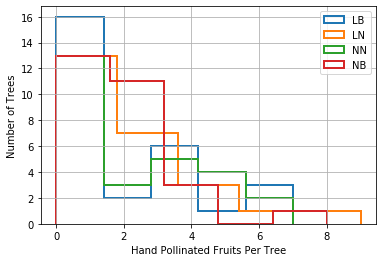

In [60]:
plotMulti1DHist(treeFruitCount,'H')

There is also no obvious difference in the number of fruits on hand-pollinated flowers.

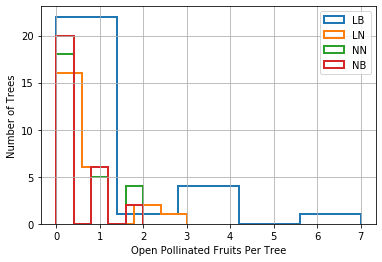

In [61]:
plotMulti1DHist(treeFruitCount,'O')

However! It looks like this long LB tail in the open pollinated sample could be interesting.

No obvious differences in LN or NB compared to NN.

# Is this statistically significant? 

## Null hypothesis: Treatments do not have an effect; identical to NN

Use hypothesis testing to compare all treatments to total

Set p-value threshold to .... 1\%

### Welch's t-test: 
Used when samples have unequal sizes and variances: 

$\frac{\mu_1-\mu_2}{s_\bar{\Delta}}$

where

$s_\bar{\Delta}=\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}$

(where $\mu_i$, $s_i$, and $n_i$ are the mean, standard deviation, and number of participants respectively in group $i$).

In our case, group 2 is NN and we will compare each of the alternatives to this.

In [62]:
treatments=list(treeFruitCount['Treatment'].unique())
pollination=['O']

# first calculate group2 stuff
# list order: mu, s, n
group2 = {'O':[treeFruitCount.loc[treeFruitCount['Treatment']=='NN']['fruitCountO'].mean()
               ,treeFruitCount.loc[treeFruitCount['Treatment']=='NN']['fruitCountO'].var()
               ,treeFruitCount.loc[treeFruitCount['Treatment']=='NN']['fruitCountO'].count()
              ]
         }

fullTreatmentList,fullPollinationList,fullMeanList,fullVarList,fullCountList,fullTTestList=[],[],[],[],[],[]

for treatment,polli in itertools.product(treatments,pollination):
    fullTreatmentList.append(treatment)
    fullPollinationList.append(polli)
    
    thisCount=treeFruitCount.loc[treeFruitCount['Treatment']==treatment]['fruitCount'+polli]
    fullMeanList.append(thisCount.mean())
    fullVarList.append(thisCount.var())
    fullCountList.append(thisCount.count())
    tTest=(thisCount.mean()-group2[polli][0])/np.sqrt(thisCount.var()/thisCount.count() + group2[polli][1]/group2[polli][2])
    fullTTestList.append(tTest)

In [63]:
resultsDF=pd.DataFrame(list(zip(fullTreatmentList,fullPollinationList,fullMeanList,fullVarList,fullCountList,fullTTestList))
                       ,columns=['Treatment','Pollination','Mean','Variance','Count','tTest'])

In [64]:
resultsDF

,Treatment,Pollination,Mean,Variance,Count,tTest
0,LB,O,1.071429,2.883598,28,1.675446
1,LN,O,0.520000,0.676667,25,0.175693
2,NB,O,0.357143,0.386243,28,-0.666596
3,NN,O,0.481481,0.566952,27,0.000000


The largest excess is roughly 1.7 sigma -- not enough to claim significance but certainly worth further investigation.

This investigation could be improved with better controlling for the many other features in the dataset, or possibly collecting more data if needed.

This is before checking for any correlations with other features of the dataset (e.g. amount of sunlight, size of tree, etc).

## What other factors are important?

### Check possible correlations between open pollinated fruit count and other features.
These would need to be addressed before publishing the result above


In [65]:
treeFruitCount.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 0 to 107
Data columns (total 13 columns):
Chakra         108 non-null object
Tree           108 non-null int64
Treatment      108 non-null object
Type           108 non-null object
Trunk Cir.     108 non-null int64
Canopy HT      108 non-null float64
Water          108 non-null object
Shade          108 non-null int64
Cover          108 non-null int64
ChakraTree     108 non-null object
fruitCount     108 non-null int64
fruitCountO    108 non-null int64
fruitCountH    108 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 16.8+ KB


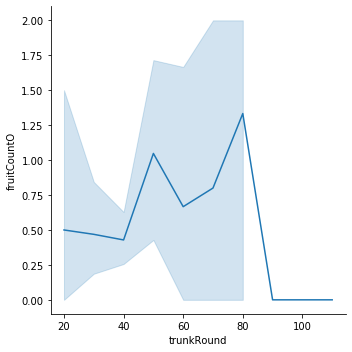

In [66]:
treeFruitCount['trunkRound']=treeFruitCount['Trunk Cir.'].apply(lambda x : round(x,-1))
sns.relplot(x='trunkRound',y='fruitCountO',data=treeFruitCount,kind='line')

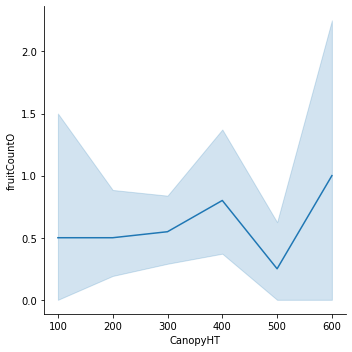

In [67]:
treeFruitCount['CanopyHT']=treeFruitCount['Canopy HT'].apply(lambda x : round(x,-2))
sns.relplot(x='CanopyHT',y='fruitCountO',data=treeFruitCount,kind='line')

Possible slight positive correlations between tree size and number of fruits -- of course!

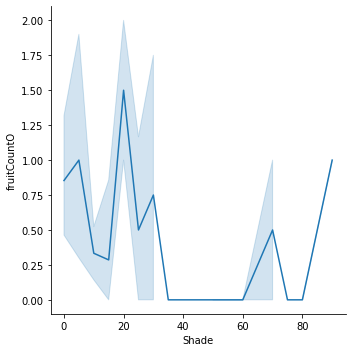

In [68]:
sns.relplot(x='Shade',y='fruitCountO',data=treeFruitCount,kind='line')

Possible slight negative correlation.

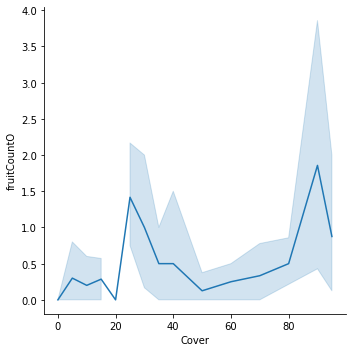

In [69]:
sns.relplot(x='Cover',y='fruitCountO',data=treeFruitCount,kind='line')

Possible positive correlation here.

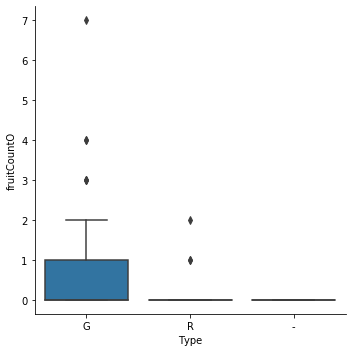

In [70]:
sns.catplot(x="Type", y="fruitCountO",
            kind="box", data=treeFruitCount)

It looks like 'G' type trees have more success with open fruit pollination, but 'G' population is just bigger to begin with (see EDA).

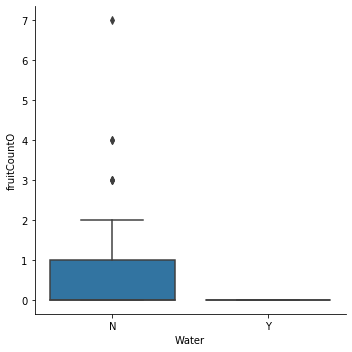

In [71]:
sns.catplot(x="Water", y="fruitCountO",
            kind="box", data=treeFruitCount)

Trees with water have fewer fruits. However similarly as tree type, this category was vastly imbalanced to begin with so it's hard to draw a correlation here.

### Would applying the treatments be worth it? 
In other words, would the cost of applying the treatment yield more fruit than the equivalent cost of hand-pollinating?

Without a significant increase in open pollinated fruits using the treatment methods, I would not recommend it. 

However there is a slight excess which should be followed up with more robust data processing or more data if needed.

If the excess persists or increases, the farmers should compare the net profits of continued hand pollination versus switching (at least in part) to the treatment method to decide whether applying the treatments would be worth it.

Final thought on this: Just look at the hand vs open fruit count distributions comparing only LB and NN. The similarity between "open LB" and the hand pollinated categories is certainly compelling.

Text(0, 0.5, 'Number of Trees')

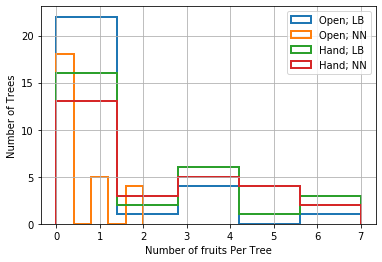

In [72]:
openLB = treeFruitCount.loc[treeFruitCount.Treatment=='LB'].fruitCountO.hist(bins=5,label='Open; LB',histtype='step',linewidth=2)
openNN = treeFruitCount.loc[treeFruitCount.Treatment=='NN'].fruitCountO.hist(bins=5,label='Open; NN',histtype='step',linewidth=2)
handLB = treeFruitCount.loc[treeFruitCount.Treatment=='LB'].fruitCountH.hist(bins=5,label='Hand; LB',histtype='step',linewidth=2)
handNN = treeFruitCount.loc[treeFruitCount.Treatment=='NN'].fruitCountH.hist(bins=5,label='Hand; NN',histtype='step',linewidth=2)
plt.legend()
plt.xlabel('Number of fruits Per Tree')
plt.ylabel('Number of Trees')

### Other important takeaways

Check out insect database real quick.

In [73]:
specimens.head()

,Essig_ID,CollE,Chakra,Tree,Storage,Order,Family,Sex
0,1166083,2016,SJ1,11,"TB101 (1,1)",Hymen,Platy,NaN
1,1166084,2016,SJ1,11,"TB101 (1,2)",Diptera,Cecido,Female
2,1166085,2016,SJ1,10,"TB101 (1,3)",Diptera,Cera,NaN
3,1166086,2016,SJ1,10,"TB101 (1,4)",Diptera,Cecido,Male
4,1166087,2016,SJ1,10,"TB101 (1,5)",Diptera,Cecido,Female


In [74]:
specimens['ChakraTree']=specimens['Chakra'].str.cat(specimens['Tree'].astype(str))

In [75]:
specimenTrees = pd.merge(trees,specimens,on='ChakraTree',how='left')

Text(0, 0.5, 'Number of insect recordings')

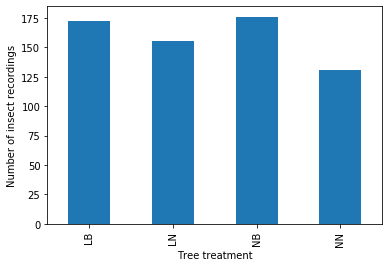

In [76]:
specimenTrees.groupby(specimenTrees['Treatment']).Water.count().plot(kind='bar')
plt.xlabel('Tree treatment')
plt.ylabel('Number of insect recordings')

This does suggest that more insects are near the treated trees. Perhaps the difference in pollination will become more apparent with more time / more data.